In [1]:
import cv2
import pytesseract
import time
from flask import Flask, request, jsonify
import os
import PIL as plt
import matplotlib.pyplot as plt
from werkzeug.utils import secure_filename
import numpy as np

In [6]:
pytesseract.pytesseract.tesseract_cmd ='/usr/local/bin/tesseract'

app = Flask(__name__)


@app.route('/upload', methods=['POST'])
def upload_file():
    if 'file' not in request.files:
        return jsonify({'error': 'No file part'}), 400
    file = request.files['file']
    if file.filename == '':
        return jsonify({'error': 'No selected file'}), 400
    if file:
        filename = secure_filename(file.filename)
        file.save(filename)  # Save the file directly using the sanitized filename
        
        image = cv2.imread(filename)

        # Now convert the image to the HSV color space
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        lower_red = np.array([0, 120, 70])
        upper_red = np.array([10, 255, 255])
        lower_red2 = np.array([170, 120, 70])
        upper_red2 = np.array([180, 255, 255])
        lower_blue = np.array([100, 150, 0])
        upper_blue = np.array([140, 255, 255])
        lower_white = np.array([0, 0, 200])
        upper_white = np.array([180, 55, 255])



        mask_red1 = cv2.inRange(hsv_image, lower_red, upper_red)
        mask_red2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
        mask_red = cv2.bitwise_or(mask_red1, mask_red2)
        mask_blue = cv2.inRange(hsv_image, lower_blue, upper_blue)
        mask_white = cv2.inRange(hsv_image, lower_white, upper_white)


        def white_content_inside(contour, mask_white ):
            x, y, w, h = cv2.boundingRect(contour)

            submask = mask_white[y:y+h, x:x+w]

            return np.count_nonzero(submask)
        
        def create_json_response(extracted_text, color_name):
            # Construct and return a dictionary for the item
            return {
                "nombre": extracted_text,
                "color": color_name
            }
        
        




        contours_red, _ = cv2.findContours(mask_red, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours_blue, _ = cv2.findContours(mask_blue, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)



        most_white_red_contour = max(contours_red, key=lambda c: white_content_inside(c, mask_white), default=None)
        most_white_blue_contour = max(contours_blue, key=lambda c: white_content_inside(c, mask_white), default=None)



        # Function to apply preprocessing and show results
        def preprocess_and_show(img, method_name, color_name):
            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if method_name != 'Grayscale' else img

            # Apply preprocessing based on the method
            if method_name == 'Otsu Thresholding':
                _, processed_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            elif method_name == 'Adaptive Thresholding':
                processed_img = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
            elif method_name == 'Morphological Operations':
                kernel = np.ones((1, 1), np.uint8)
                processed_img = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
                processed_img = cv2.morphologyEx(processed_img, cv2.MORPH_CLOSE, kernel)
            elif method_name == 'Sharpening Filter':
                kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
                processed_img = cv2.filter2D(gray, -1, kernel)
            else:
                processed_img = gray

            # OCR with Tesseract
            extracted_text = pytesseract.image_to_string(processed_img)



            return create_json_response(extracted_text, color_name)


        ocr_results = []
        for contour, color_name in [(most_white_red_contour, "Rojo"), (most_white_blue_contour, "Azul")]:
            if contour is not None:
                x, y, w, h = cv2.boundingRect(contour)
                color_section = image[y:y+h, x:x+w]

                methods = ['Grayscale', 'Otsu Thresholding', 'Adaptive Thresholding', 'Morphological Operations', 'Sharpening Filter']
                for method in methods:
                    ocr_results.append(preprocess_and_show(color_section, method, color_name))

        

        
        os.remove(filename)

        return jsonify(ocr_results)
    
    
if __name__ == '__main__':
    app.run(debug=True, host='0.0.0.0', port=3000, use_reloader=False)





 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:3000
 * Running on http://192.168.1.6:3000
Press CTRL+C to quit
192.168.1.6 - - [09/Feb/2024 08:47:11] "POST /upload HTTP/1.1" 200 -


Gana Azul


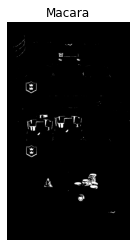

In [2]:
image_path = '/Users/santiamoretti/Downloads/ClashRoyale.jpg' 
image = cv2.imread(image_path)


if image is None:
    print("Error")
    exit()


hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)


lower_color = np.array([20, 100, 100])  
upper_color = np.array([30, 255, 255])


mask = cv2.inRange(hsv_image, lower_color, upper_color)


height = mask.shape[0]
upper_half_mask = mask[:height//2, :]
lower_half_mask = mask[height//2:, :]


upper_half_count = np.count_nonzero(upper_half_mask)
lower_half_count = np.count_nonzero(lower_half_mask)



if upper_half_count > lower_half_count:
    print("Gana rojo")
elif lower_half_count > upper_half_count:
    print("Gana Azul")
else:
    print("las dos partes tienen la misma cantidad")


plt.imshow(mask, cmap='gray')
plt.title("Macara")
plt.axis('off')
plt.show()

In [14]:
from fuzzywuzzy import fuzz


tesseract_output = "Vous :\n\n\"}pas de clan le\nR\u00e9compense\n\na\n\nam\n\n1 \u201c\nCoffre en bois Os\n"


database_value = "Vous"


match_percentage = fuzz.partial_ratio(tesseract_output, database_value)

print(match_percentage)  


100


In [ ]:
!pip install fuzzywuzzy